# Read Libs

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os

# display and output settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML


display(HTML('''
<style>
    .container { width:85% !important; }
</style>
'''))

pd.set_option('display.min_rows', 100)

# Read Files In

In [2]:
path_data_hourly_raw = "../data/raw_data/weather/hourly_weather/"

In [3]:
folders_batches = list(filter(lambda x: x != ".DS_Store", os.listdir(path_data_hourly_raw)))
folders_batches = sorted(map(lambda x: int(x), folders_batches))

In [4]:
list_df_weather = []

# loop through the folders and get the latest file in each folder 
for batch in folders_batches:
    # get the list of files in the batch folder
    files_timestamps_in_batch = os.listdir(path_data_hourly_raw + str(batch))
    # remove the .DS_Store file
    files_timestamps_in_batch = list(filter(lambda x: x != ".DS_Store", files_timestamps_in_batch))

    # pull the latest file in the batch
    folder_latest_timestamp = max(files_timestamps_in_batch)
    file_name_csv = "hourly_weather_data.csv"

    df_batch_weather = pd.read_csv(os.path.join(path_data_hourly_raw, str(batch), folder_latest_timestamp, file_name_csv))
    list_df_weather.append(df_batch_weather)

df_hourly_weather = pd.concat(list_df_weather, axis=0, ignore_index=True)
    

# Compare Distances from Weather Actual City Pulled and Tournament City

In [12]:
df_hourly_weather.head(3)

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,event_id,round,weather_url,tournament_city,actual_weather_city
0,5:00 AM,34 °F,27 °F,75 °%,NW,5 °mph,0 °mph,28.70 °in,0.0 °in,Fair,2,1,https://www.wunderground.com/history/daily/RJO...,"Kapalua, HI","Mihara, Hiroshima, Japan"
1,6:00 AM,32 °F,28 °F,87 °%,NW,8 °mph,0 °mph,28.70 °in,0.0 °in,Fair,2,1,https://www.wunderground.com/history/daily/RJO...,"Kapalua, HI","Mihara, Hiroshima, Japan"
2,7:00 AM,32 °F,27 °F,80 °%,WNW,3 °mph,0 °mph,28.73 °in,0.0 °in,Fair,2,1,https://www.wunderground.com/history/daily/RJO...,"Kapalua, HI","Mihara, Hiroshima, Japan"


### Use GeoPy Lib and Create Functions

In [5]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

def geocode_city(city_name):
    """
    Geocode a city name to obtain its geographical location.
    This function uses the Nominatim geocoding service to convert a city name into its corresponding geographical location (latitude and longitude).
    Args:
        city_name (str): The name of the city to geocode.
    Returns:
        location (Location or None): A Location object containing the geographical coordinates of the city if successful, or None if the geocoding times out.
    Raises:
        GeocoderTimedOut: If the geocoding request times out.
    """

    geolocator = Nominatim(user_agent="my_geocoder")
    try:
        location = geolocator.geocode(city_name, timeout=10)
        return location
    except GeocoderTimedOut:
        print(f"Geocoding timed out for city: {city_name}")
        return None

def get_distance(city1, city2):
    """
    Calculate the distance in miles between two cities using their geographical coordinates.
    Args:
        city1 (obj): object of matched city with geopy.
        city2 (obj): object of matched city with geopy.
    Returns:
        float: The distance between the two cities in miles.
    Raises:
        GeocoderTimedOut: If the geocoding service times out.
        GeocoderServiceError: If there is an issue with the geocoding service.
        AttributeError: If the geocoding service does not return valid coordinates for the cities.
    """
    try:
        distance = geodesic((city1.latitude, city1.longitude), 
                        (city2.latitude, city2.longitude)).miles
        
        return distance

    except:
        return None

    


In [6]:
# test_object = geocode_city("Kapalua, HI")
# test_object
# test_object[0]
# test_object.latitude

# get_distance("Kapalua, HI", "Mihara, Hiroshima, Japan")

### Create Column for GeoPy matched City Name

#### Aggregate/select distinct dataframe to city levels

In [44]:
df_distinct_cities = \
df_hourly_weather[['tournament_city', 'actual_weather_city']].drop_duplicates().reset_index(drop=True)


In [45]:
df_distinct_cities['geopy_city_match_tournament'] = df_distinct_cities['tournament_city'].apply(lambda x: geocode_city(x))
df_distinct_cities['geopy_city_match_weather'] = df_distinct_cities['actual_weather_city'].apply(lambda x: geocode_city(x))

### Create Distance Column Between Geopy Matched City

In [ ]:
df_distinct_cities['distance_between_cities'] = \
df_distinct_cities.apply(lambda x: get_distance(x['geopy_city_match_tournament'], x['geopy_city_match_weather']), axis=1)

### EDA on Distances

In [66]:
print(" describe entire data frame \n-----------\n")
df_distinct_cities.describe()


 describe entire data frame 
-----------



,distance_between_cities
count,253.000000
mean,478.154960
std,1625.582132
min,0.000000
25%,1.762107
50%,10.654821
75%,24.758772
max,10526.609132


In [65]:

print(" describe filtered data frame \n-----------\n")
df_distinct_cities[df_distinct_cities['distance_between_cities'] < 1000].describe()


 describe filtered data frame 
-----------



,distance_between_cities
count,230.000000
mean,34.442402
std,109.486928
min,0.000000
25%,0.000000
50%,9.949146
75%,19.595706
max,862.670225


<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Distances Between Cities')

Text(0.5, 0, 'Distance (miles)')

Text(0, 0.5, 'Frequency')

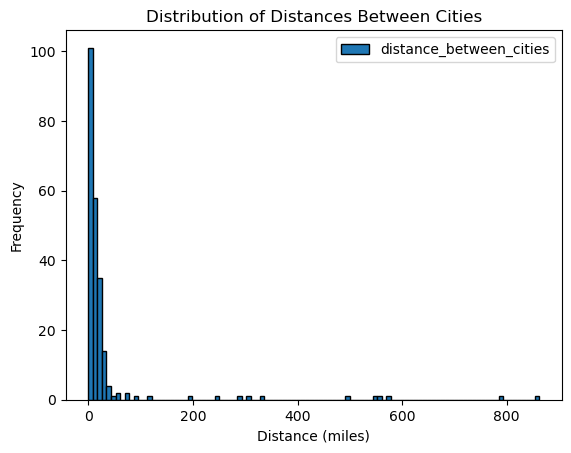

In [67]:

import matplotlib.pyplot as plt

df_distinct_cities[df_distinct_cities['distance_between_cities'] < 1000]\
    .plot(kind='hist', bins=100, edgecolor='black')


plt.title('Distribution of Distances Between Cities')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.show()

### Create Flag for Valid Weather Data

In [58]:
# set the threshold distance to x miles
# choosing 35 miles as the threshold distance

threshold_distance = 35
df_distinct_cities['flag_valid_weather'] = df_distinct_cities['distance_between_cities'].apply(lambda x: 'Y' if x < threshold_distance else 'N')

### Join Back to Hourly Weather

In [72]:
# filtering the data frame to only include the valid weather data
df_valid_weather = df_distinct_cities\
    [df_distinct_cities['flag_valid_weather'] == 'Y']\
        [['tournament_city', 'distance_between_cities', 'flag_valid_weather']]

In [74]:
# inner join to get the valid weather data only 
df_hourly_weather_valid = pd.merge(df_hourly_weather, 
         df_valid_weather,
         on='tournament_city', 
         how='inner'
         )

In [77]:
# comparing the number of unique events in the original and valid weather data frames
df_hourly_weather['event_id'].nunique()
df_hourly_weather_valid['event_id'].nunique()

1525

1381

# Write to File to Preserve Geopy API required lookups 

In [79]:
output_path = "../data/transformed_data/weather_data/valid_weather_geopy"

timestamp_run = dt.datetime.now().strftime('%Y-%m-%d %Hh%Mm%Ss')

os.mkdir(os.path.join(output_path, timestamp_run))

df_hourly_weather_valid.to_csv(f'{output_path}/{timestamp_run}/valid_geopy_hourly_weather.csv', index=False)